# Stroke Prediction

## Imports

In [1]:
# installs
# !pip install opendatasets --upgrade
# !pip install -U imbalanced-learn

# imports
import warnings
warnings.simplefilter('ignore')


# imports 
from wrangle import get_data_csv, wrangle_data
from explore import (get_age_visual,
                     get_blood_sugar_visual,
                     get_gender_visual, 
                     get_stroke_visual,
                     eval_results)
from model import preprocess, predictions, voting_predictions

## Acquire

* This data was acquired by accessing Kaggle's data API on April 27th, 2023
* There are 5110 observations and 12 features
    * One observation is one person
    * Each feature is a different characteristics about a person

In [2]:
# importing data
get_data_csv().head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


## Prepare

#### Clean 
>    * Renamed columns to be pythonic
>    * Dropped the 'smoking_status' column because 30% of the column values were 'Unknown'
>    * Dropped the 'id' column because it will not add value during exploration or modeling
>    * Dropped rows that were missing 'bmi' vlaues becasue they only made up 3% of the observations
>    * *Outliers* remained becasue with health outliers can be a significant indicator for different illnesses or risk for illnesses

#### Prepare
> Bins were created for the following features:
>    * *age:* Bins made based on what decade of years an individual had were created.
>    * *bmi:* Five bins created. BMI has many correlations with health complications, but it is not a true measure of body fat. 5 bins based on the values present in the dataset were used instead of bins based on common interpretations.
        * Source: https://onlinelibrary.wiley.com/doi/abs/10.1046/j.1467-789x.2001.00031.x
>    * *avg_glucose_level:* There is not enough information to determine what tests were used (fasting, glucose tolerance test, or random) to calculate the average glucose level. The ranges proposed by the Glucose Tolerance Test from the CDC will be used as different categories in combination with Cleveland Clinic recommendation.
        * Source: https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test
        * Source: https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.
#### Split
>The data was split into train, validate, and test

In [3]:
# getting prepared and split data
train, validate, test = wrangle_data()

## Explore

### 1. What does stroke look like in the dataset?

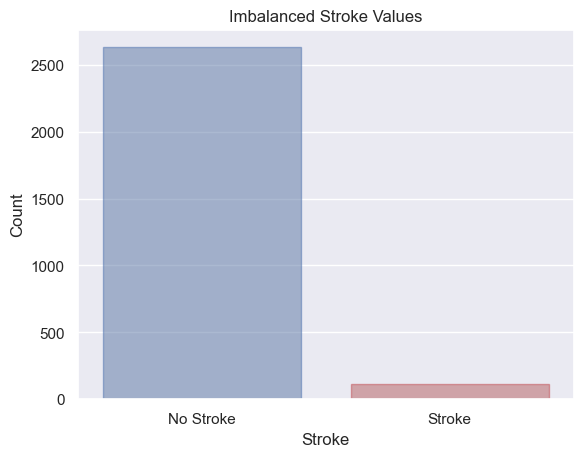

In [4]:
# get visual
get_stroke_visual(train)

##### Takeaways:
* The dataset is very imbalanced
* The vast majority of the dataset contains observations without stroke which may cause challenges during modeling

 ### 2. Is there a relationship age and stroke?

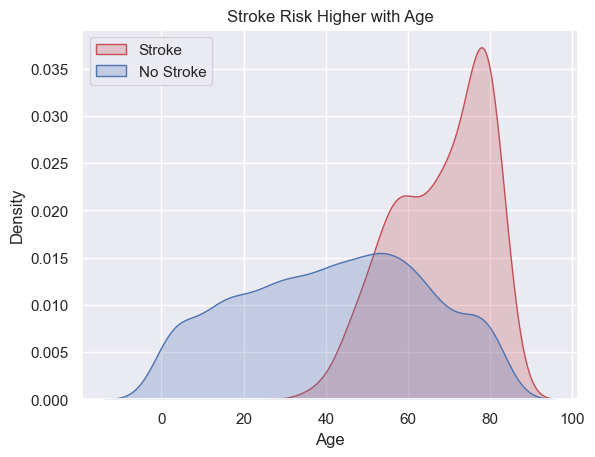

In [5]:
# get unbinned visual, a density plot, and binned visuals
get_age_visual(train)

>##### Takeaways:
>* There is a significantly higher number of older individuals having strokes than younger individuals

> ##### Chi-Squared:
>- H$_0$: There is not a significant relationship between stroke and age.
>- H$_a$: There is a significant relationship between stroke and age.
>- Confidence Interval: 95%
>- $a$: 0.05

In [6]:
# get stats results
eval_results(train, 'age_bins')

There exists some relationship between stroke and age bins. (p-value: 1.1233708410310633e-33)


We can reject the null hypothesis.

### 3. Is there a relationship between gender and stroke?

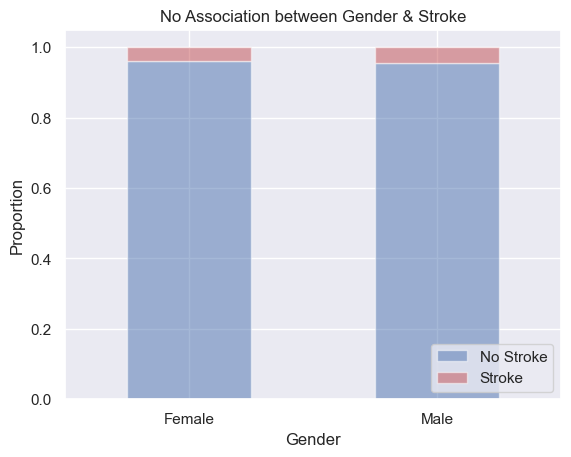

In [7]:
# get unbinned visual, a density plot, and binned visuals
get_gender_visual(train)

> ##### Takeaways:
> * There doesn't appear to be a relationship between gender and stroke.
> * 'Other': The lack of stroke in it's proportions is not because of the  of strokes relationship to the other gender, but becasue the other gender is especially small in this dataset.

> ##### Chi-Squared:
>- H$_0$: There is not a significant relationship between stroke and gender.
>- H$_a$: There is a significant relationship between stroke and gender.
>- Confidence Interval: 95%
>- $a$: 0.05

In [8]:
# get stats results
eval_results(train, 'gender')

There is not a significant relationship between stroke and gender. (p-value: 0.5046362035822145)


We cannot reject the null hypothesis.

### 4. Is there a relationship between blood sugar level and stroke?

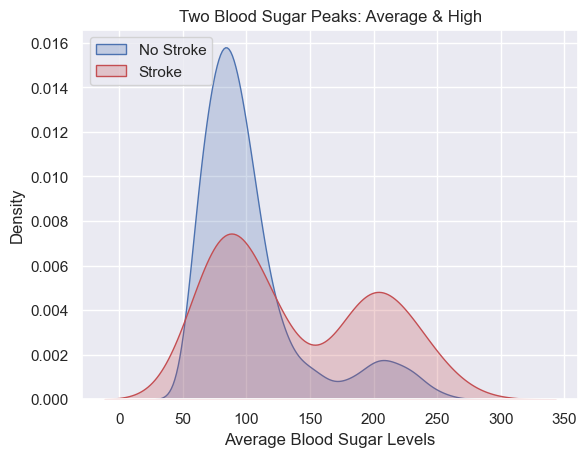

In [9]:
# getting blood sugar
get_blood_sugar_visual(train)

>##### Takeaways:
>* There appears to be two clusters of people, one cluster with average blood sugar and one group with high blood suger.
>* There appears to be a relationship between high blood sugar and stroke. 
>* Exploring  individuals with average blood sugar levels and stroke may be useful for identifying other features of interest that increase the risk of stroke for this group.

> ##### Chi-Squared:
>- H$_0$: There is not a significant relationship between stroke and blood sugar levels.
>- H$_a$: There is a significant relationship between stroke and blood sugar levels.
>- Confidence Interval: 95%
>- $a$: 0.05

In [10]:
# getting stats
eval_results(train, 'glucose_bins')

There exists some relationship between stroke and glucose bins. (p-value: 1.0801654601493803e-13)


We can reject the null hypothesis.

## Exploration Summary
* The dataset is imbalanced
* Age and blood sugar appear to have an association with stroke
* Gender did not have a relationship with stroke

**Features for modeling:**
* 'hypertension'
* 'heart_disease'
* 'age_bins'
* 'glucose_bins'
* 'bmi_bins'
* 'ever_married'
* 'work_type'

## Modeling

In [11]:
# preprocessing
X_train, y_train, X_resample, y_resample, X_validate, y_validate, X_test, y_test = preprocess()

### Introduction
* Models will be evaluated using recall score as the focus
* Strokes can be life threatening conditions. Correctly identifying those with the highest risk of stroke could potentially save lives. Recall scores allow us to understamd how often True Positives (stroke) are predicted by the model. 
* The baseline is a constant value of zero, which represents no stroke, becasue this was the most occuring value.

### Models and Scores

In [12]:
# getting predictons on train
predictions(X_resample, y_resample, X_train, y_train).T

Algorithm,Baseline,GradientBoosting,LR C=.25,LR C=.5,LogisticRegression,SVC,VotingClassifier
Recall Score,0.0,81.0,81.0,81.0,78.0,84.0,82.0
Accuracy Score,96.0,75.0,64.0,65.0,68.0,70.0,65.0
Precision Score,0.0,12.0,9.0,9.0,10.0,11.0,9.0
f1 Score,0.0,21.0,16.0,17.0,17.0,19.0,17.0
Confusion Matrix,"[[2631, 0], [117, 0]]","[[1953, 678], [22, 95]]","[[1676, 955], [22, 95]]","[[1695, 936], [22, 95]]","[[1772, 859], [26, 91]]","[[1820, 811], [19, 98]]","[[1696, 935], [21, 96]]"


In [13]:
# getting predictons on validate
predictions(X_resample, y_resample, X_validate, y_validate).T

Algorithm,Baseline,GradientBoosting,LR C=.25,LR C=.5,LogisticRegression,SVC,VotingClassifier
Recall Score,0.0,68.0,80.0,82.0,78.0,78.0,82.0
Accuracy Score,96.0,74.0,65.0,65.0,68.0,69.0,65.0
Precision Score,0.0,10.0,9.0,9.0,10.0,10.0,9.0
f1 Score,0.0,18.0,16.0,17.0,17.0,17.0,17.0
Confusion Matrix,"[[1129, 0], [50, 0]]","[[836, 293], [16, 34]]","[[726, 403], [10, 40]]","[[726, 403], [9, 41]]","[[760, 369], [11, 39]]","[[770, 359], [11, 39]]","[[726, 403], [9, 41]]"


In [14]:
# getting difference between train and validate
(predictions(X_resample, y_resample, X_train, y_train) - predictions(X_resample, y_resample, X_validate, y_validate)).T

Algorithm,Baseline,GradientBoosting,LR C=.25,LR C=.5,LogisticRegression,SVC,VotingClassifier
Recall Score,0.0,13.0,1.0,-1.0,0.0,6.0,0.0
Accuracy Score,0.0,1.0,-1.0,0.0,0.0,1.0,0.0
Precision Score,0.0,2.0,0.0,0.0,0.0,1.0,0.0
f1 Score,0.0,3.0,0.0,0.0,0.0,2.0,0.0
Confusion Matrix,"[[1502, 0], [67, 0]]","[[1117, 385], [6, 61]]","[[950, 552], [12, 55]]","[[969, 533], [13, 54]]","[[1012, 490], [15, 52]]","[[1050, 452], [8, 59]]","[[970, 532], [12, 55]]"


### Test
* When running these models with no set random state, their strength varies. Logistic Regression maintains the most stable scores between test and validate, but often performs with a smaller recall score than the others.
* There are often large differences in performance between the train and validate sets.
* We will use a VotingClassifier model that uses all models to decide what to do. This will allow us to maintin consistently strong results, reducing the impact of the random state and the data fed to the model.

In [15]:
# getting the voting classifier scores on test
voting_predictions(X_resample, y_resample, X_test, y_test)

Algorithm,VotingClassifier_uniform
Recall Score,83.0
Accuracy Score,66.0
Precision Score,10.0
f1 Score,17.0
Confusion Matrix,"[[614, 326], [7, 35]]"


### Modeling Wrap 
* All models performed better than the baseline when using recall as the core metric

## Conclusion

### Summary
* Stroke represented roughly 5% of the data which influenced the decision to oversample to accomodate for an imbalanced dataset
* Demographically, only age had a significant relationship to stroke, while gender's independence could not be rejected
* Average blood sugar level was found to have a statistically significant relationship to stroke
* Preprocessing included oversampling as mentioned previously
* Models created varied in strength and consistency therefore a VotingClassifier combining the results of the three strongest and most consistent models was used
* On test, this model performed with a 83% recall and a 66% accuracy.

### Recommendations
* Acquire more health and demographic data
* Increase the robustness of the smoking_status data
* Use this model as a preliminary screening tool to asses stroke risk

### Next Steps
* Explore a mulit-variate analysis
* Feature engineer using clustering to further explore the blood sugar levels
* Adjust hyperparameters of models